In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm
import reverse_geocoder as rg
from deap import base, creator, tools
import random

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
from preprocessing.pre_process_traffic import *
from preprocessing.helping_functions import *

from features.config import *
from features.question_2_financials import *

from models.question_1 import *
from models.question_2 import *

from models.genetic_algorithm_part3_1 import *

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class Config:
    PATH = '../../data/'

class Params:
    PARAM = 0
config = Config()
p = Params()

## Load data

In [4]:
def load_data():
    ##### Load new coordinates
    df_new_points = gpd.read_file(config.PATH+'new_coordinates/new_coordinates.shp')

    ##### Load hub data 
    df_hub_dense = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_denses.shp')
    df_hub_enlarged = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_elargies.shp')

    ##### Load traffic data
    df_traffic = gpd.read_file(config.PATH+'E-tmja2019-shp/TMJA2019.shp')
    df_traffic = preprocess_data(df_traffic)
    df_traffic = fix_tmja(df_traffic)

    df_new_points = distance_to_hub(df_hub_dense, df_hub_enlarged, df_new_points)

    df_traffic = df_traffic.groupby('route')[['TMJA_PL','percentage_traffic']].sum().reset_index(drop=False)
    df_new_points = df_new_points.merge(df_traffic, how='left', on='route')
    df_new_points = station_distances_all(df_new_points)

    data_region = gpd.read_file(config.PATH+'regions-20180101-shp/regions-20180101.shp')
    df_new_points = create_region_columns(df_new_points,data_region)

    return df_new_points

In [5]:
df_new_points = load_data()

Loading formatted geocoded file...


100%|██████████| 13978/13978 [03:35<00:00, 64.80it/s]


## Genetic algorithm deap library


In [6]:
stations_per_region = {'Region': ['Hauts-de-France','Bretagne','Île-de-France','Auvergne-Rhône-Alpes','Grand Est','Nouvelle-Aquitaine','Pays de la Loire','Occitanie','Centre-Val de Loire','Bourgogne-Franche-Comté','Normandie',"Provence-Alpes-Côte d'Azur"],
'Hydrogen Stations Needed 2030': [45,41,41,34,34,34,34,30,26,23,19,15],
'Hydrogen Stations Needed 2040': [267,245,245,200,200,200,200,178,156,134,111,89]}

In [7]:
nb_stations_per_region = pd.DataFrame(stations_per_region)
nb_stations_per_region

,Region,Hydrogen Stations Needed 2030,Hydrogen Stations Needed 2040
0,Hauts-de-France,45,267
1,Bretagne,41,245
2,Île-de-France,41,245
3,Auvergne-Rhône-Alpes,34,200
4,Grand Est,34,200
5,Nouvelle-Aquitaine,34,200
6,Pays de la Loire,34,200
7,Occitanie,30,178
8,Centre-Val de Loire,26,156
9,Bourgogne-Franche-Comté,23,134


In [8]:
nb_stations_per_region['Hydrogen Stations Needed 2040'] = nb_stations_per_region['Hydrogen Stations Needed 2040'] - nb_stations_per_region['Hydrogen Stations Needed 2030']

In [9]:
list_regions = nb_stations_per_region['Region'].values

### Per region 2030

In [74]:
def genetic_algorithm(
        df_stations,
        nb_stations,
        region_name,
        evaluate,
        num_generations,
        population_size
        ):
    
    # Set up the DEAP toolbox
    creator.create("FitnessMax", base.Fitness, weights=[1.0,])
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # Register the genetic operators
    toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(df_stations.index.values), size=nb_stations, replace=False),n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Create the initial population
    population = toolbox.population(n=population_size)

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):        
        ind.fitness.values = fit

    # Set up the statistics objects to evaluate results
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("argmin", np.argmin)

    avg_fitness = []
    min_fitness = []
    max_fitness = []
    arg_min_fitness = []

    # Start the evolution process
    for generation in tqdm(range(num_generations)):
    
        population = [x for x in population if type(x)!=int]

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if type(child1[0])==int:
                child1[0] = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)
            elif type(child2[0])==int:
                child2[0] = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)
            else:
                toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        # Evaluate the new individuals
        fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, fresh_individuals)
        for ind, fit in zip(fresh_individuals, fitnesses):
            ind.fitness.values = fit

        # Add the new individuals to the population
        population[:] = offspring

        # Update the hall of fame and statistics
        record = stats.compile(population)
        avg_fitness.append(record["avg"])
        min_fitness.append(record["min"])
        max_fitness.append(record["max"])
        arg_min_fitness.append(record["argmin"])

    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

def run_ga(
        df_stations: gpd.GeoDataFrame,
        nb_stations_per_region: pd.DataFrame,
        region_name: str,
        year: int = 2030,
        num_generations: int = 30,
        population_size: int = 50):
    
    df_stations = sales(df_stations,year)
        
    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {year}'].values[0]

    total_nb_stations = df_stations.shape[0]

    # Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
    def fitness(X,nb_stations=nb_stations,data: pd.DataFrame=df_stations):
        index = X[0]

        if type(index)==int:
            index = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)

        columns_distance = [c for c in data.columns if c.startswith('distance_to_point_')==True]
        if data[data['index'].isin(list(index))].shape[0]>0:
            columns_distance_drop = [columns_distance[i] for i in index]
            data_sub = get_closer_station(data[data['index'].isin(list(index))].drop(columns=columns_distance_drop))
            # constraint make sure the closest station is closer than 120km (for trucks with autonomy of 150km)
            data_sub = data_sub[data_sub['distance_closer_station'] < 120000]
            fit = 150 - (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean())/10 + data_sub['distance_closer_station'].mean() + data_sub['Revenues_day'].mean()

        else:
            fit = -10e3
        
        return fit
    
    # Define the evaluation function
    def evaluate(individual):
        return fitness(individual),
    
    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = genetic_algorithm(
        df_stations,
        nb_stations,
        region_name,
        evaluate,
        num_generations=num_generations,
        population_size=population_size
        )
    
    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

Running genetic algorithm for Hauts-de-France


100%|██████████| 30/30 [10:52<00:00, 21.76s/it]


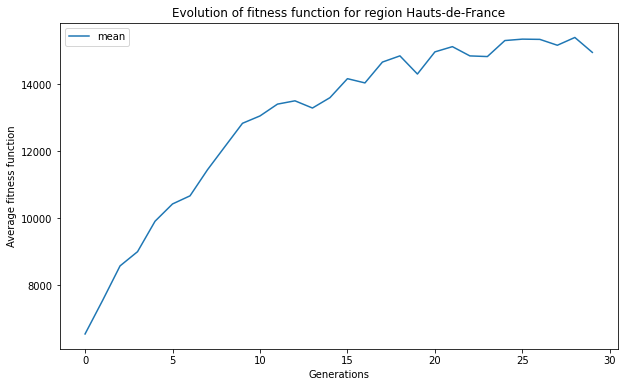

Chosen stations in Hauts-de-France for 2040 are : Int64Index([13202,  3140,  2784,  2864,   333,    95,   198,   122,   346,
              110,  6989,   159,  2748,   327,  2142,   339,  2752,  9640,
              112,  2209,   115,   127,  9410,  2152,  2753,  9729,   106,
             7073,  2195,  9886,   333,  2711,  2579,   335,  9752,   337,
             6861,  2094,   187,  2745, 13471,   147,  7097,  9879,  6936],
           dtype='int64')
Running genetic algorithm for Bretagne


100%|██████████| 30/30 [07:07<00:00, 14.24s/it]


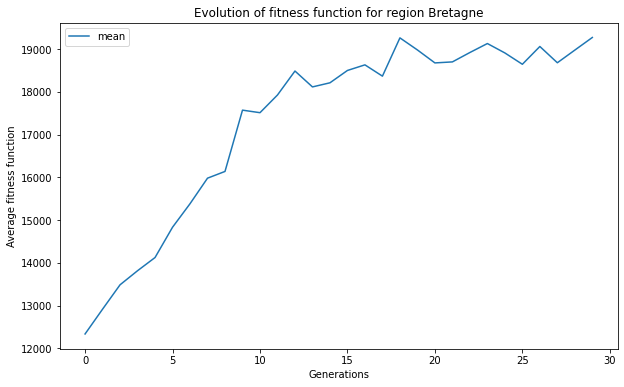

Chosen stations in Bretagne for 2040 are : Int64Index([ 8733, 12699,  8695,  8684, 12691,  5719, 12819, 12674,  8834,
             8817, 12594,  8815,  8772,  8699,  8725,  8698,  8816, 12818,
             8791,  8750, 12693,  8685,  8760,  8818,  8749,  8814,  8836,
             8702, 12524, 12737, 12700,  8827,  9343,  9328, 11898,  8726,
            12740,  8767, 11857,  8799,  5724],
           dtype='int64')
Running genetic algorithm for Île-de-France


100%|██████████| 30/30 [13:46<00:00, 27.55s/it] 


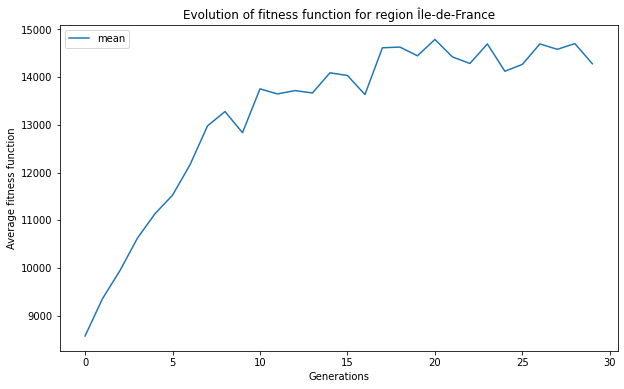

Chosen stations in Île-de-France for 2040 are : Int64Index([   56,  2019,  1413,  7343,  7376,   281,  8210,   726,   691,
              728,   686,  8480, 11296,    45,  1868,   297,   554,  6377,
             8205,  8224,   244, 11293,  1866,  7378,   277,  1409,    90,
              319,  1394, 11295, 13032,   723,  5890,    53,  8852,  7130,
             1862,  2013,   709,  1402,   691],
           dtype='int64')
Running genetic algorithm for Auvergne-Rhône-Alpes


100%|██████████| 30/30 [05:07<00:00, 10.25s/it]


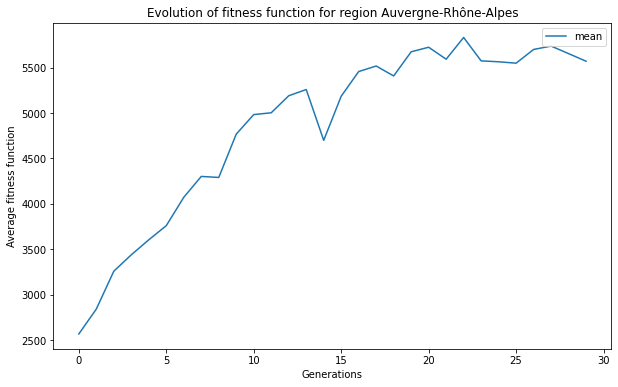

Chosen stations in Auvergne-Rhône-Alpes for 2040 are : Int64Index([ 7551,   985,  7932,   933,  7938,  7932,  7624,  4084,  7736,
             7466,  8061,  8083,  7456,  7831, 11644,  8021,  7830,  7515,
             7849,  6787,  7561,  7442,  7935,  8068,  6226,  7775,  3961,
             7748,  7785,  8054,  7794,  8053,  7898,  4119],
           dtype='int64')
Running genetic algorithm for Grand Est


100%|██████████| 30/30 [05:02<00:00, 10.09s/it]


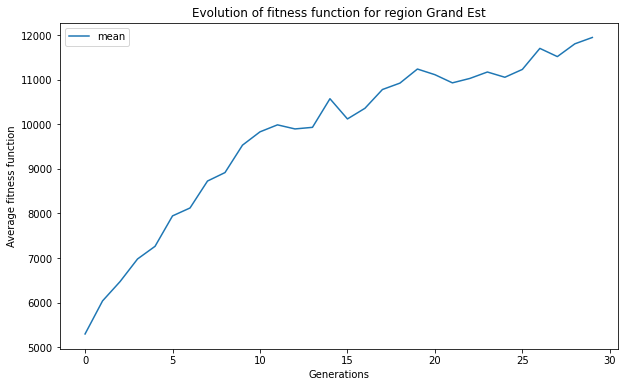

Chosen stations in Grand Est for 2040 are : Int64Index([7232,  538, 3473, 3551, 3477,  387,  419, 3479, 6536,  410, 3331,
             371,  466,  376,  421, 3359, 3468, 3473,  365, 3172,  505,  372,
            3222,  497,  368, 7203,  479, 3361,  388, 9978,  446,  486, 3427,
             358],
           dtype='int64')
Running genetic algorithm for Nouvelle-Aquitaine


100%|██████████| 30/30 [05:08<00:00, 10.28s/it]


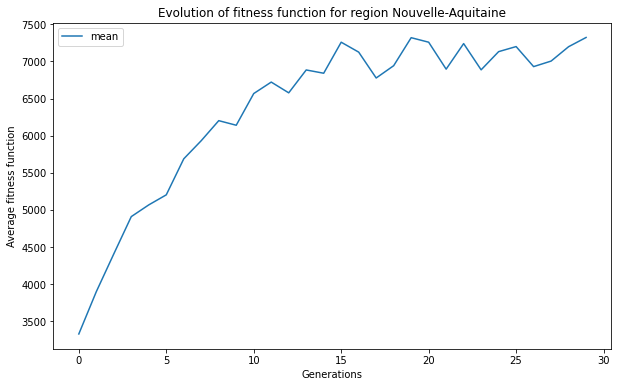

Chosen stations in Nouvelle-Aquitaine for 2040 are : Int64Index([ 6118,  8338,  6072, 13924,  4799,  1562,  6827,  1551,  4779,
             4715,  1645,  1587,  1558,  2393,  9253,  4784,  1652, 12212,
            11787,  1658,  1578,  8435,  4999, 12085,  4803,  6129,  1575,
             6141,  6097, 11977,  2389,  2433,  8342,  9192],
           dtype='int64')
Running genetic algorithm for Pays de la Loire


100%|██████████| 30/30 [04:48<00:00,  9.61s/it]


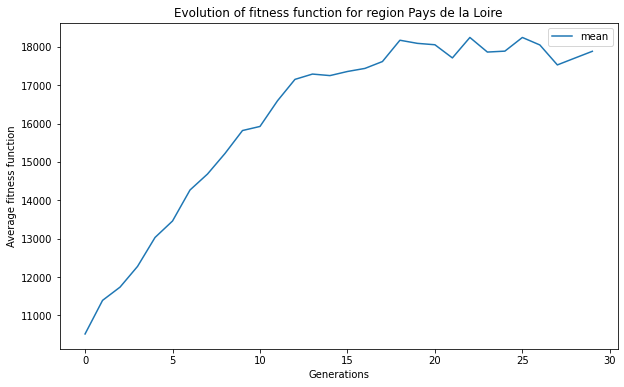

Chosen stations in Pays de la Loire for 2040 are : Int64Index([ 1801, 13761, 13741, 12666,  1825, 13800, 13757, 13804, 13803,
            12830, 13808,  2935, 12659, 13825,  5608, 13744, 13827, 13763,
             8646,  1843,  1752,  5624,  8667,  1762, 13813,  1740, 12488,
             8660,  8657, 13815,  1830,  1785,  8623, 12512],
           dtype='int64')
Running genetic algorithm for Occitanie


100%|██████████| 30/30 [04:21<00:00,  8.71s/it]


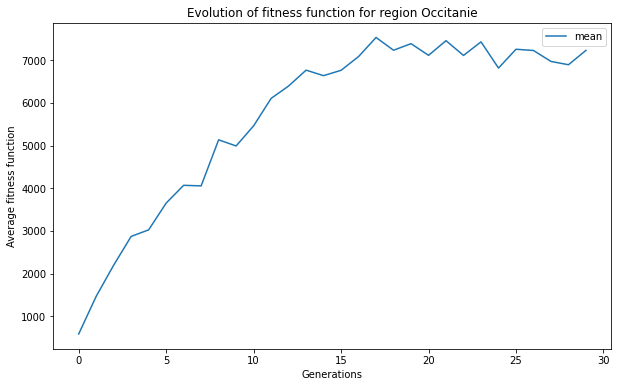

Chosen stations in Occitanie for 2040 are : Int64Index([ 1375,  4936,  4507, 11424,  6675, 10934,  2455,  2516,  1342,
             2509,  4662,  5071,  1275,  5046,  1304,  4677, 11558, 10818,
             4554,  4965,  2458,  4647,  2503, 10863,  1262,  1297,  6676,
             2490,  4524,  1362],
           dtype='int64')
Running genetic algorithm for Centre-Val de Loire


100%|██████████| 30/30 [04:03<00:00,  8.13s/it]


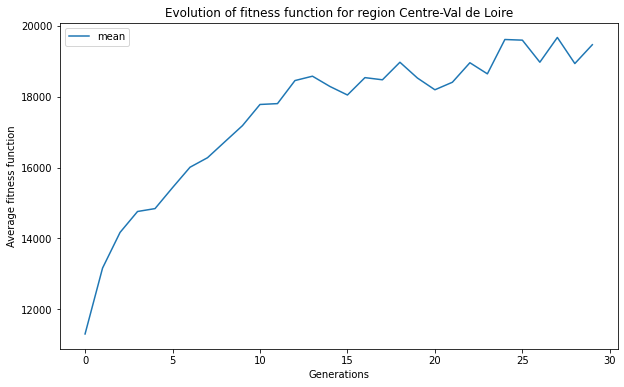

Chosen stations in Centre-Val de Loire for 2040 are : Int64Index([1476, 5147, 8237,  737, 8237, 1483, 8230, 1527, 1506, 2320, 2253,
            5180, 1494,  730,  735, 8260, 1459, 1474, 8502, 1473, 1426, 8309,
            1448, 1445, 5155, 1453],
           dtype='int64')
Running genetic algorithm for Bourgogne-Franche-Comté


100%|██████████| 30/30 [03:44<00:00,  7.48s/it]


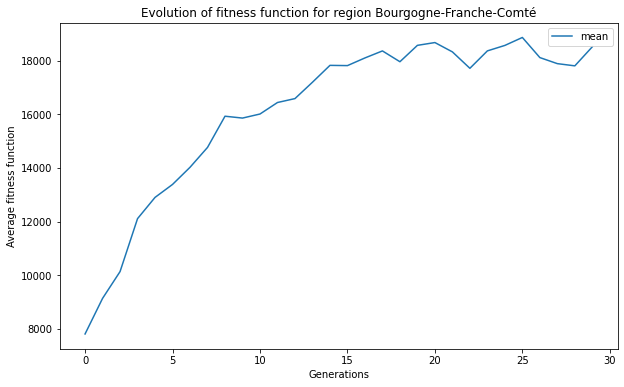

Chosen stations in Bourgogne-Franche-Comté for 2040 are : Int64Index([  887,   592,  7389,   857,  7401,   792, 10107,  3199,   789,
             3796,  3178,  3179,   840,  3614,  3226,  3705,   868,  7392,
             3201,  3614,  3186,  3197,  7389],
           dtype='int64')
Running genetic algorithm for Normandie


100%|██████████| 30/30 [03:33<00:00,  7.12s/it]


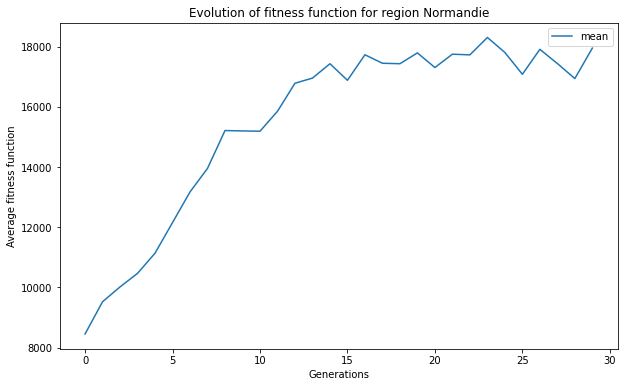

Chosen stations in Normandie for 2040 are : Int64Index([ 2993,  1955,  1910,  8897,  1909,  8874,  8587, 13932,  8558,
             1972,  1920,  8593,  1982,  1947,  8607,  2971,  5754,  8573,
             1932],
           dtype='int64')
Running genetic algorithm for Provence-Alpes-Côte d'Azur


100%|██████████| 30/30 [03:20<00:00,  6.68s/it]


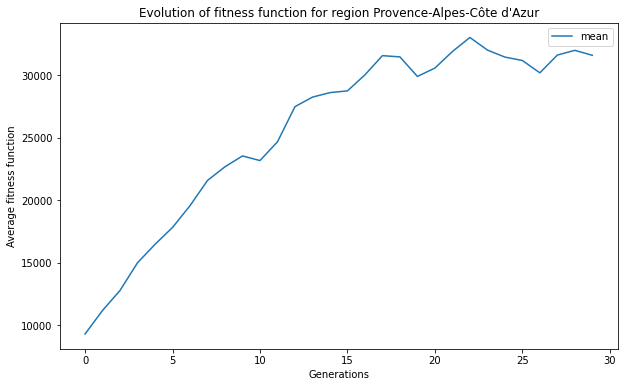

Chosen stations in Provence-Alpes-Côte d'Azur for 2040 are : Int64Index([ 1030,  8158,  8186,  1016,  4408,  6651,  8169,  8119,  8195,
             8146,  1243,  8116, 11469,  8161,  8136],
           dtype='int64')


In [78]:
chosen_stations_2030 = pd.DataFrame([])

for region_name in list_regions:
    print(f'Running genetic algorithm for {region_name}')

    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {2030}'].values[0]

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points[df_new_points[region_name]==True],
        nb_stations_per_region, 
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2030_per_reg['Region'] = region_name

    chosen_stations_2030 = pd.concat([chosen_stations_2030,chosen_stations_2030_per_reg],axis=0)

    plot_fitness_functions(avg_fitness,region_name)
    print(f'Chosen stations in {region_name} for 2030 are : {chosen_stations_2030_per_reg.index}')

In [79]:
chosen_stations_2030 = sales(chosen_stations_2030, 2030)
chosen_stations_2030 = station_type(chosen_stations_2030,df_station_info)

876.0


In [151]:
results_2030 = pd.read_csv('results_stations_2030_part_3_1.csv')
results_2040 = pd.read_csv('results_stations_2040_part_3_1.csv')

In [155]:
[i for i in results_2030['index'].values if i in results_2040['index'].values]

[]

In [152]:
results_2040.shape

(2225, 22)

### Per region 2040


In [81]:
df_new_points = sales(df_new_points,2040)

In [82]:
df_new_points_without_2030 = df_new_points.drop(index=chosen_stations_2030.index.values)

Running genetic algorithm for Hauts-de-France


100%|██████████| 30/30 [21:17<00:00, 42.59s/it]


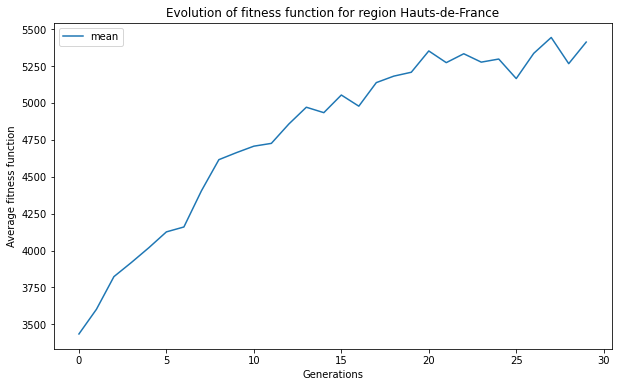

Chosen stations in Hauts-de-France for 2040 are : Int64Index([ 9477,  2693,  2163, 13467,  2192,  9703,    92, 13214,  9475,
             7078,
            ...
              167,  2568,  9452,  2527, 13386,  2135,  2074,   111,   105,
             2742],
           dtype='int64', length=267)
Running genetic algorithm for Bretagne


100%|██████████| 30/30 [16:34<00:00, 33.15s/it]


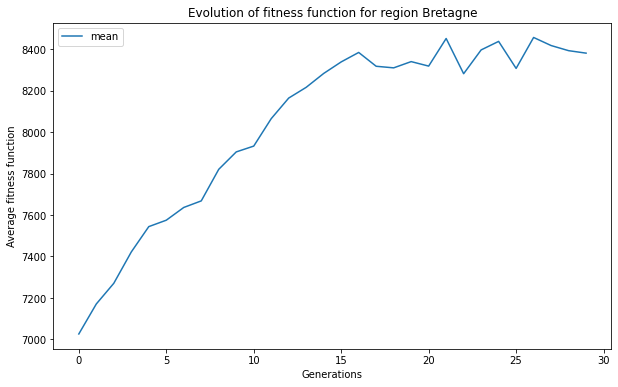

Chosen stations in Bretagne for 2040 are : Int64Index([13305,  8757,  8723,  8700,  9349, 11867, 12675, 12929, 12517,
             9336,
            ...
             9379,  8713, 12391,  8835, 12749, 12791, 12764, 13309,  5703,
             8820],
           dtype='int64', length=245)
Running genetic algorithm for Île-de-France


100%|██████████| 30/30 [16:33<00:00, 33.13s/it]


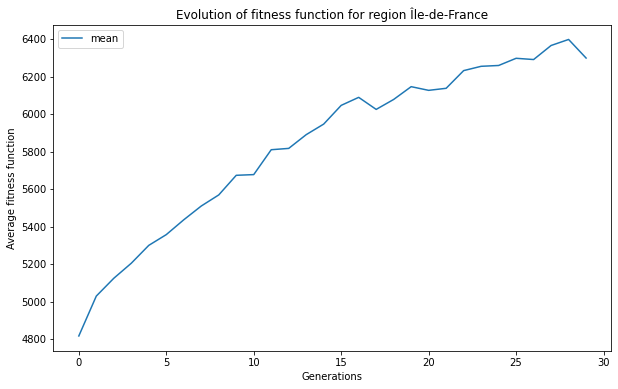

Chosen stations in Île-de-France for 2040 are : Int64Index([ 2044,  8221,   553,   267, 11588, 11294,   716,   572,  5919,
             8203,
            ...
              713,  7331,  5891,  9859,   702, 11589,    62,  8472,    70,
             8487],
           dtype='int64', length=245)
Running genetic algorithm for Auvergne-Rhône-Alpes


100%|██████████| 30/30 [14:42<00:00, 29.41s/it]


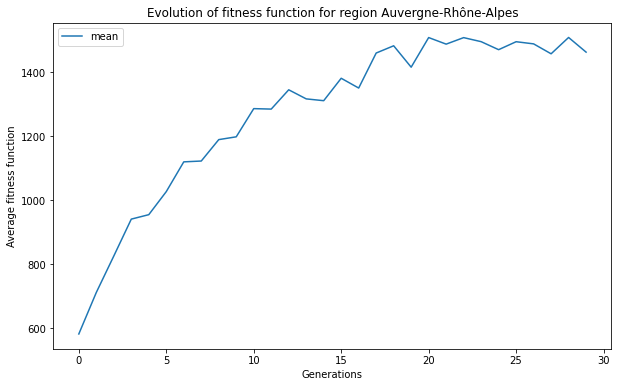

Chosen stations in Auvergne-Rhône-Alpes for 2040 are : Int64Index([ 8037,  7664,  7518, 10740,  4157, 11004,  4080,    15,   901,
            11054,
            ...
             6642,  4027, 11624, 11174,  7717, 11667,  7591,  6625,  3858,
             7708],
           dtype='int64', length=200)
Running genetic algorithm for Grand Est


100%|██████████| 30/30 [14:22<00:00, 28.74s/it]


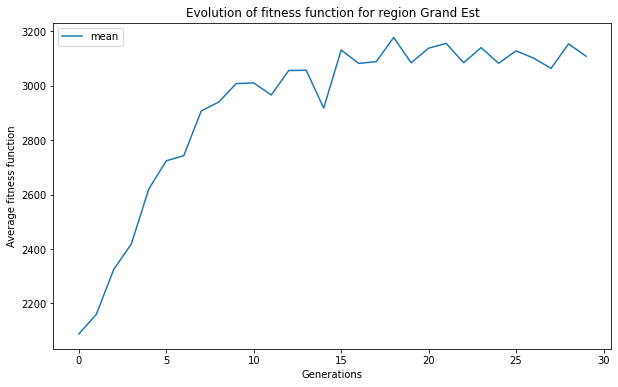

Chosen stations in Grand Est for 2040 are : Int64Index([ 3560,   418, 10009,  9012,  3601,   360,  9776,   436,   431,
              529,
            ...
             3584, 10186,  3544,   647,  6495,  3595,   426,  3367,   472,
             3592],
           dtype='int64', length=200)
Running genetic algorithm for Nouvelle-Aquitaine


100%|██████████| 30/30 [14:39<00:00, 29.31s/it]


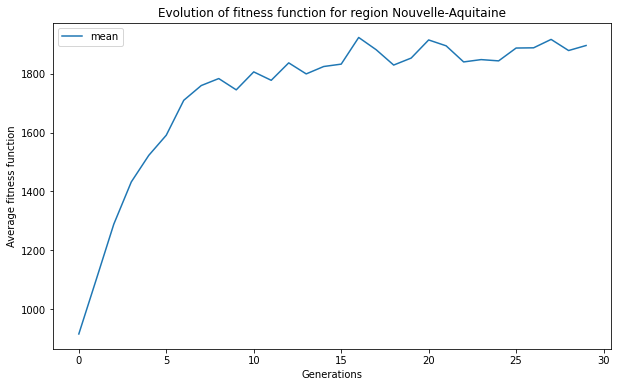

Chosen stations in Nouvelle-Aquitaine for 2040 are : Int64Index([ 5697,  6078,  8375,  2372,  8396,  6816,  4788,  1548,  2422,
             9193,
            ...
             4748, 13601,  4981,  4735,  4744,  6738,  4796,  5044, 12147,
             1656],
           dtype='int64', length=200)
Running genetic algorithm for Pays de la Loire


100%|██████████| 30/30 [14:06<00:00, 28.22s/it]


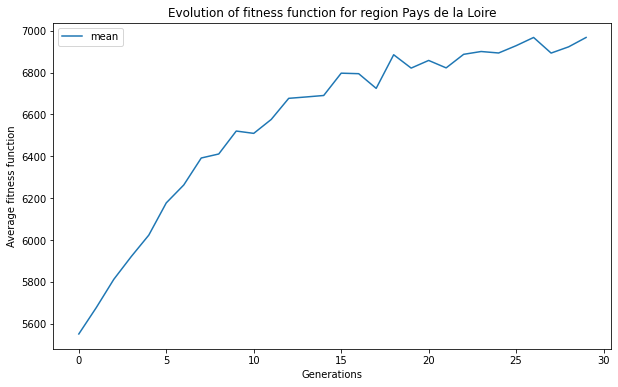

Chosen stations in Pays de la Loire for 2040 are : Int64Index([13819,  5962, 13269, 12496,  5953,  5647,  1778,  8664,  1819,
            13746,
            ...
             1747, 13812, 13278,  6811,  5594, 12636,  6029,  2965,  5661,
             8624],
           dtype='int64', length=200)
Running genetic algorithm for Occitanie


100%|██████████| 30/30 [13:38<00:00, 27.27s/it]


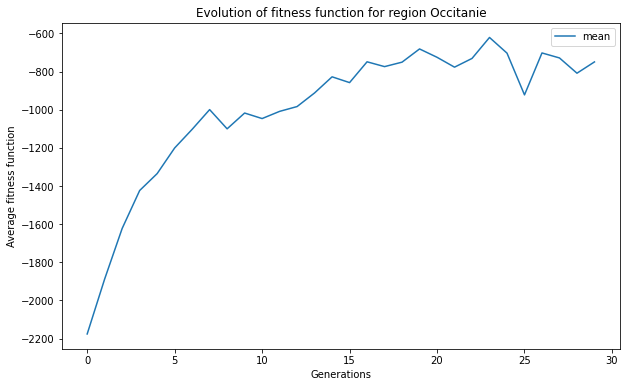

Chosen stations in Occitanie for 2040 are : Int64Index([ 4680, 10876,  5371,  1298, 10963,  4553, 11540,  5083,  1300,
            11601,
            ...
             4510, 13419, 11400,  5395,  2508,  5377, 11538, 11500,  1281,
            11606],
           dtype='int64', length=178)
Running genetic algorithm for Centre-Val de Loire


100%|██████████| 30/30 [11:20<00:00, 22.69s/it]


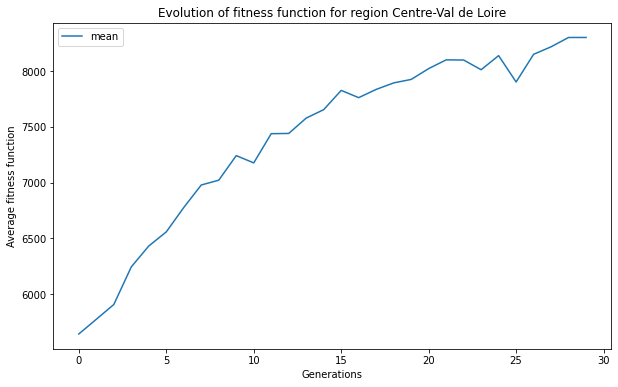

Chosen stations in Centre-Val de Loire for 2040 are : Int64Index([ 2318,  1721,  1421,  8235, 12348,  8236,  2285,  1444,  8241,
             2326,
            ...
             5099,  2266,  5119,  2338, 12326,  1429, 12360, 12346,  1457,
             5125],
           dtype='int64', length=156)
Running genetic algorithm for Bourgogne-Franche-Comté


100%|██████████| 30/30 [10:50<00:00, 21.68s/it]


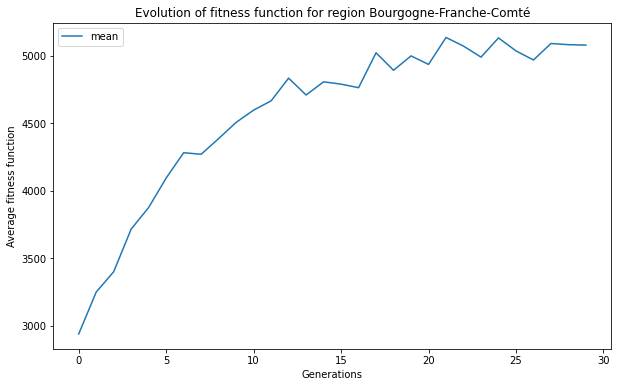

Chosen stations in Bourgogne-Franche-Comté for 2040 are : Int64Index([13328, 10485, 13866,  3693,   784, 13336,  3667, 13900,   862,
              808,
            ...
            13846,   570,  3218, 13319,  3706,   794,  7294,  3183,  3642,
             7381],
           dtype='int64', length=134)
Running genetic algorithm for Normandie


100%|██████████| 30/30 [09:16<00:00, 18.54s/it]


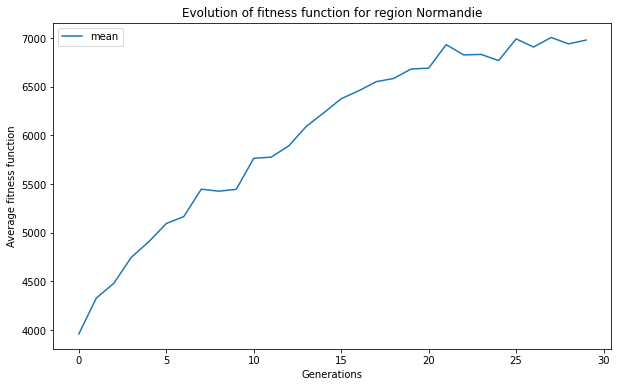

Chosen stations in Normandie for 2040 are : Int64Index([ 1974,  3042, 13724,  1931,  6060,  1965,  3056,  8581,  6403,
             6382,
            ...
             9587,  8608,  8561,  2999,  8552, 12877, 11972,  3054,  8538,
             8531],
           dtype='int64', length=111)
Running genetic algorithm for Provence-Alpes-Côte d'Azur


100%|██████████| 30/30 [07:54<00:00, 15.82s/it]


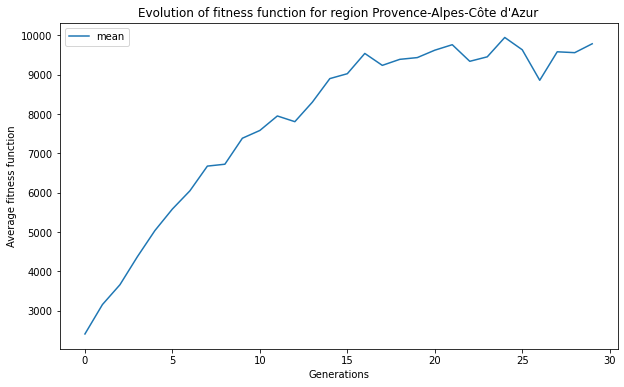

Chosen stations in Provence-Alpes-Côte d'Azur for 2040 are : Int64Index([10702,  1179,  1189,  1209,  8173, 13142,  8153,  8118, 13122,
            10705,  8137,  1021,  4439,  1069,  4336,  8151,  1149,  8114,
             1215,  8121, 13698,  1077,  8191,  4331,  1227,  8153,  1171,
             8144,  1183, 10671,  1249,  8197, 11070,  1019, 13687,  4277,
            10720,  1067,  4442,  1236, 11088,  4441,  8124, 10658,  8128,
             8194,  1088, 11465,  1153, 13368,  1152,  8144,  8190,  1082,
             1017,  1155,  8188,  8122,  4317,  1081, 10674,  1046,  4414,
             8182,  1159,  1095,  4343,  8175,  4309,  1215,  8150,  4434,
             1248,  1195,  1087, 11467,  4301,  8152,  8149,  1077,  4305,
             1075,  4277,  8117, 10679,  1170,  4284,  8196, 11063],
           dtype='int64')


In [83]:
chosen_stations_2040 = pd.DataFrame([])

for region_name in list_regions:
    print(f'Running genetic algorithm for {region_name}')

    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {2040}'].values[0]

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points_without_2030[df_new_points_without_2030[region_name]==True],
        nb_stations_per_region, 
        region_name=region_name,
        year = 2040,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2040_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2040_per_reg['Region'] = region_name

    chosen_stations_2040 = pd.concat([chosen_stations_2040,chosen_stations_2040_per_reg],axis=0)

    plot_fitness_functions(avg_fitness,region_name)
    print(f'Chosen stations in {region_name} for 2040 are : {chosen_stations_2040_per_reg.index}')

In [98]:
chosen_stations_2040 = sales(chosen_stations_2040, 2040)
chosen_stations_2040 = station_type(chosen_stations_2040,df_station_info)

876.0


Running genetic algorithm for Hauts-de-France


100%|██████████| 30/30 [21:17<00:00, 42.59s/it]


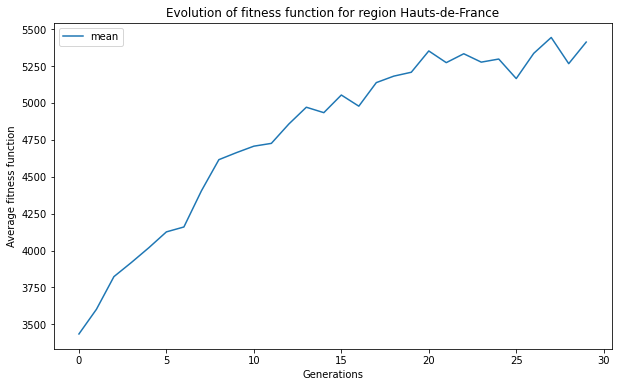

Chosen stations in Hauts-de-France for 2040 are : Int64Index([ 9477,  2693,  2163, 13467,  2192,  9703,    92, 13214,  9475,
             7078,
            ...
              167,  2568,  9452,  2527, 13386,  2135,  2074,   111,   105,
             2742],
           dtype='int64', length=267)
Running genetic algorithm for Bretagne


100%|██████████| 30/30 [16:34<00:00, 33.15s/it]


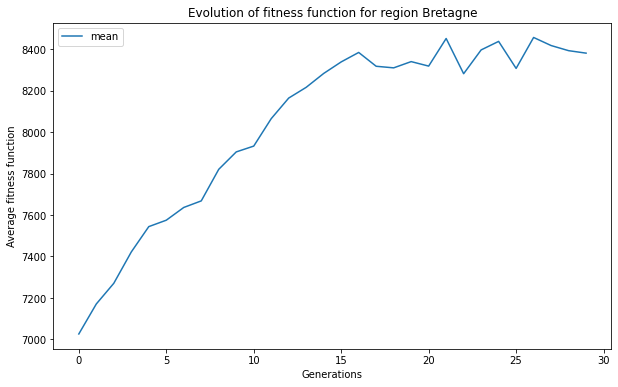

Chosen stations in Bretagne for 2040 are : Int64Index([13305,  8757,  8723,  8700,  9349, 11867, 12675, 12929, 12517,
             9336,
            ...
             9379,  8713, 12391,  8835, 12749, 12791, 12764, 13309,  5703,
             8820],
           dtype='int64', length=245)
Running genetic algorithm for Île-de-France


100%|██████████| 30/30 [16:33<00:00, 33.13s/it]


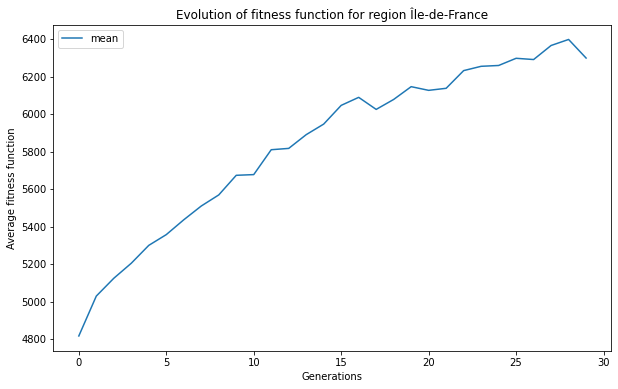

Chosen stations in Île-de-France for 2040 are : Int64Index([ 2044,  8221,   553,   267, 11588, 11294,   716,   572,  5919,
             8203,
            ...
              713,  7331,  5891,  9859,   702, 11589,    62,  8472,    70,
             8487],
           dtype='int64', length=245)
Running genetic algorithm for Auvergne-Rhône-Alpes


100%|██████████| 30/30 [14:42<00:00, 29.41s/it]


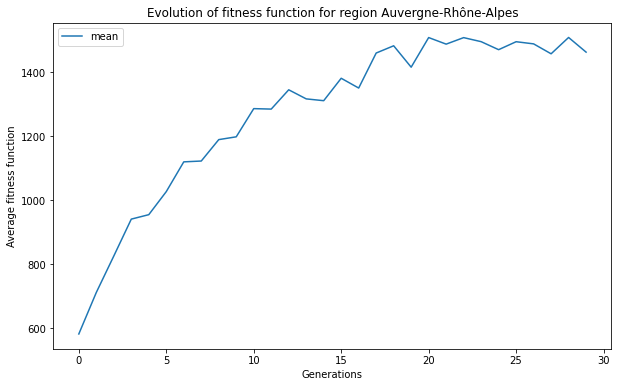

Chosen stations in Auvergne-Rhône-Alpes for 2040 are : Int64Index([ 8037,  7664,  7518, 10740,  4157, 11004,  4080,    15,   901,
            11054,
            ...
             6642,  4027, 11624, 11174,  7717, 11667,  7591,  6625,  3858,
             7708],
           dtype='int64', length=200)
Running genetic algorithm for Grand Est


100%|██████████| 30/30 [14:22<00:00, 28.74s/it]


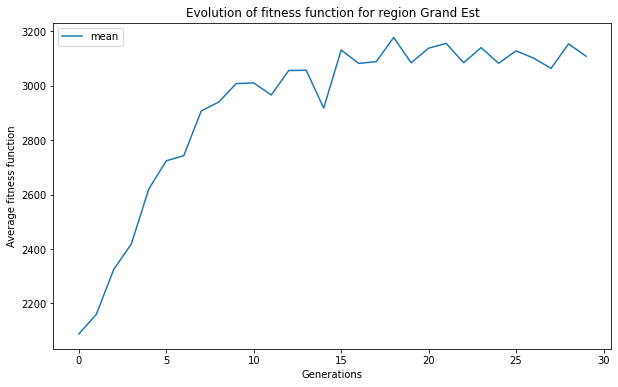

Chosen stations in Grand Est for 2040 are : Int64Index([ 3560,   418, 10009,  9012,  3601,   360,  9776,   436,   431,
              529,
            ...
             3584, 10186,  3544,   647,  6495,  3595,   426,  3367,   472,
             3592],
           dtype='int64', length=200)
Running genetic algorithm for Nouvelle-Aquitaine


100%|██████████| 30/30 [14:39<00:00, 29.31s/it]


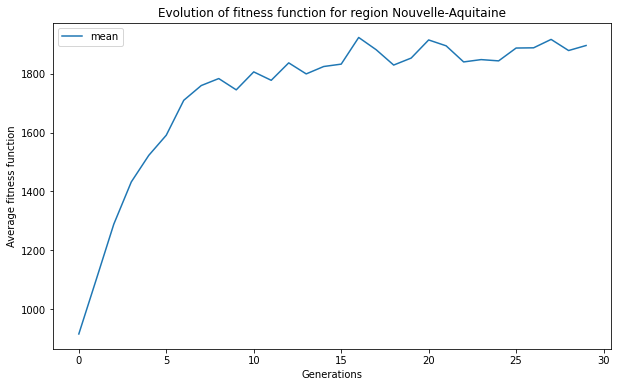

Chosen stations in Nouvelle-Aquitaine for 2040 are : Int64Index([ 5697,  6078,  8375,  2372,  8396,  6816,  4788,  1548,  2422,
             9193,
            ...
             4748, 13601,  4981,  4735,  4744,  6738,  4796,  5044, 12147,
             1656],
           dtype='int64', length=200)
Running genetic algorithm for Pays de la Loire


100%|██████████| 30/30 [14:06<00:00, 28.22s/it]


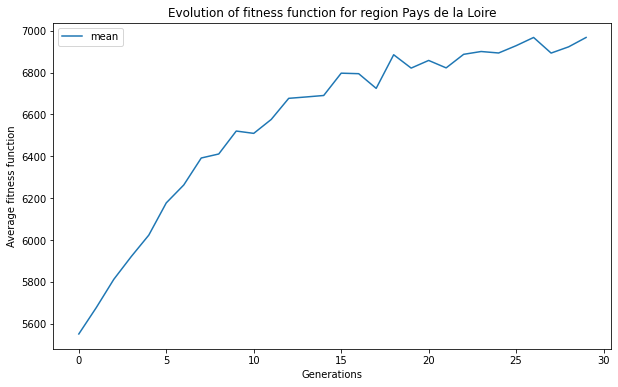

Chosen stations in Pays de la Loire for 2040 are : Int64Index([13819,  5962, 13269, 12496,  5953,  5647,  1778,  8664,  1819,
            13746,
            ...
             1747, 13812, 13278,  6811,  5594, 12636,  6029,  2965,  5661,
             8624],
           dtype='int64', length=200)
Running genetic algorithm for Occitanie


100%|██████████| 30/30 [13:38<00:00, 27.27s/it]


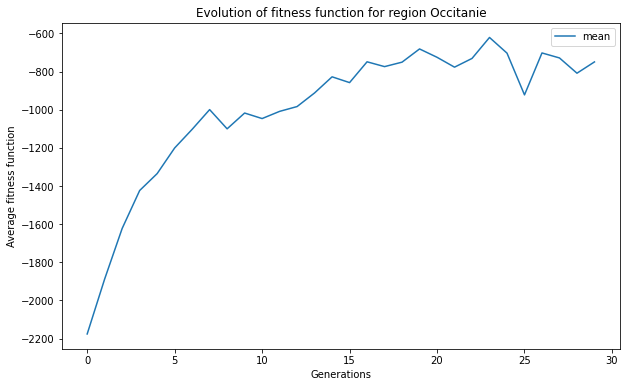

Chosen stations in Occitanie for 2040 are : Int64Index([ 4680, 10876,  5371,  1298, 10963,  4553, 11540,  5083,  1300,
            11601,
            ...
             4510, 13419, 11400,  5395,  2508,  5377, 11538, 11500,  1281,
            11606],
           dtype='int64', length=178)
Running genetic algorithm for Centre-Val de Loire


100%|██████████| 30/30 [11:20<00:00, 22.69s/it]


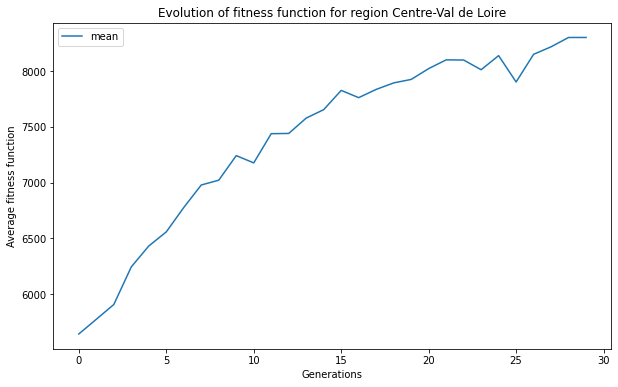

Chosen stations in Centre-Val de Loire for 2040 are : Int64Index([ 2318,  1721,  1421,  8235, 12348,  8236,  2285,  1444,  8241,
             2326,
            ...
             5099,  2266,  5119,  2338, 12326,  1429, 12360, 12346,  1457,
             5125],
           dtype='int64', length=156)
Running genetic algorithm for Bourgogne-Franche-Comté


100%|██████████| 30/30 [10:50<00:00, 21.68s/it]


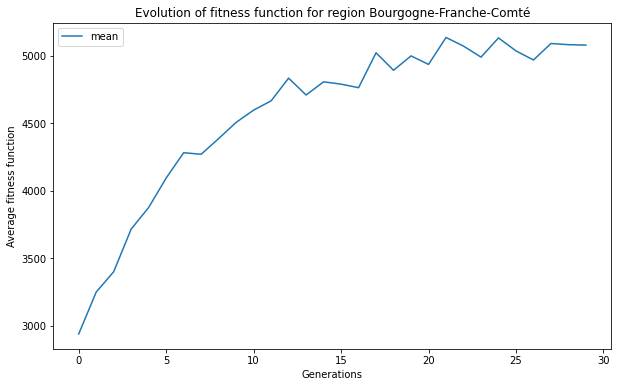

Chosen stations in Bourgogne-Franche-Comté for 2040 are : Int64Index([13328, 10485, 13866,  3693,   784, 13336,  3667, 13900,   862,
              808,
            ...
            13846,   570,  3218, 13319,  3706,   794,  7294,  3183,  3642,
             7381],
           dtype='int64', length=134)
Running genetic algorithm for Normandie


100%|██████████| 30/30 [09:16<00:00, 18.54s/it]


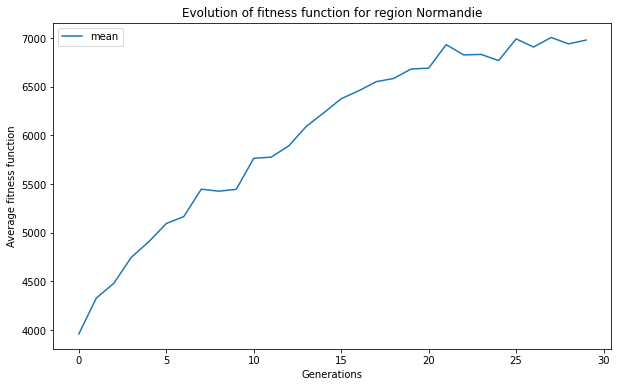

Chosen stations in Normandie for 2040 are : Int64Index([ 1974,  3042, 13724,  1931,  6060,  1965,  3056,  8581,  6403,
             6382,
            ...
             9587,  8608,  8561,  2999,  8552, 12877, 11972,  3054,  8538,
             8531],
           dtype='int64', length=111)
Running genetic algorithm for Provence-Alpes-Côte d'Azur


100%|██████████| 30/30 [07:54<00:00, 15.82s/it]


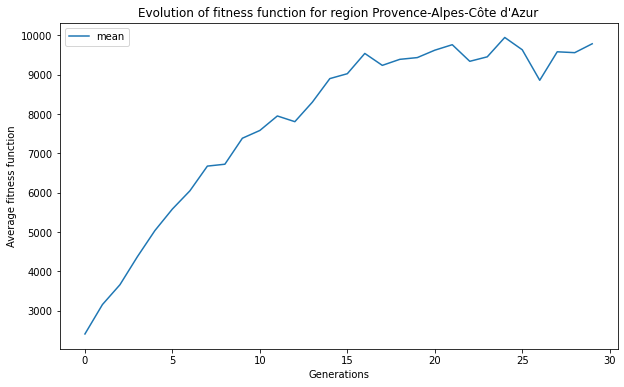

Chosen stations in Provence-Alpes-Côte d'Azur for 2040 are : Int64Index([10702,  1179,  1189,  1209,  8173, 13142,  8153,  8118, 13122,
            10705,  8137,  1021,  4439,  1069,  4336,  8151,  1149,  8114,
             1215,  8121, 13698,  1077,  8191,  4331,  1227,  8153,  1171,
             8144,  1183, 10671,  1249,  8197, 11070,  1019, 13687,  4277,
            10720,  1067,  4442,  1236, 11088,  4441,  8124, 10658,  8128,
             8194,  1088, 11465,  1153, 13368,  1152,  8144,  8190,  1082,
             1017,  1155,  8188,  8122,  4317,  1081, 10674,  1046,  4414,
             8182,  1159,  1095,  4343,  8175,  4309,  1215,  8150,  4434,
             1248,  1195,  1087, 11467,  4301,  8152,  8149,  1077,  4305,
             1075,  4277,  8117, 10679,  1170,  4284,  8196, 11063],
           dtype='int64')


In [ ]:
chosen_stations_2040 = pd.DataFrame([])

for region_name in list_regions:
    print(f'Running genetic algorithm for {region_name}')

    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {2040}'].values[0]

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points_without_2030[df_new_points_without_2030[region_name]==True],
        nb_stations_per_region, 
        region_name=region_name,
        year = 2040,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2040_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2040_per_reg['Region'] = region_name

    chosen_stations_2040 = pd.concat([chosen_stations_2040,chosen_stations_2040_per_reg],axis=0)

    plot_fitness_functions(avg_fitness,region_name)
    print(f'Chosen stations in {region_name} for 2040 are : {chosen_stations_2040_per_reg.index}')

In [164]:
chosen_stations_2040_clean.to_csv('results_stations_2040_part_3_1.csv')

In [162]:
chosen_stations_2040_clean = pd.DataFrame([])
for region_name in list_regions:
    nb_station = nb_stations_per_region[nb_stations_per_region['Region']==region_name]['Hydrogen Stations Needed 2040'].values[0]
    clean_stations = chosen_stations_2040[chosen_stations_2040['Region']==region_name][:nb_station]
    chosen_stations_2040_clean = pd.concat([chosen_stations_2040_clean,clean_stations],axis=0)

## Part 2.2

- done !

## Part 3.3

- add distance to all total stations and add it to fitness function to maximise it
- focus on a niche total is not very present and where traffic is quite high --> conventional for production but more risky for profitability


In [10]:
def station_distances_station_total(
        df_stations_total: pd.DataFrame,
        df_stations: pd.DataFrame
):
    '''
    Add columns of the distances between each stations 
    '''

    for i in tqdm(df_stations_total['index']):
        station_index = df_stations_total.loc[i, 'index']
        df_stations[f'distance_to_stationtotal_{station_index}'] = df_stations_total.loc[i, 'geometry'].distance(df_stations['geometry'])

    return df_stations

In [11]:
df_stations_total = pd.read_csv(config.PATH + 'I-Données_de_stations_improved.csv')
df_stations_total = df_stations_total[df_stations_total['H2 Conversion']==1]
df_stations_total = df_stations_total.groupby(['URL'])[['nom_region','geometry']].first()
df_stations_total = df_stations_total.reset_index(drop=False)
df_stations_total = convert_str_geometry_to_geometry_geometry(df_stations_total)
df_stations_total = df_stations_total.reset_index(drop=False)


In [12]:
df_new_points = station_distances_station_total(
        df_stations_total,
        df_new_points
)

100%|██████████| 296/296 [00:04<00:00, 61.06it/s]


In [13]:
df_new_points

,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,TMJA_PL,...,distance_to_stationtotal_286,distance_to_stationtotal_287,distance_to_stationtotal_288,distance_to_stationtotal_289,distance_to_stationtotal_290,distance_to_stationtotal_291,distance_to_stationtotal_292,distance_to_stationtotal_293,distance_to_stationtotal_294,distance_to_stationtotal_295
0,0,511656.784599997,6204078.3607,31D0044,POINT (511656.785 6204078.361),1.0,0 80409.81839 dtype: float64,5.0,0 77833.926035 dtype: float64,0.0,...,148171.808889,591569.028918,503073.605698,675427.779000,186040.203345,584169.903376,247596.554394,148176.079561,460437.871533,875928.386269
1,1,511677.2349017429,6204069.939337369,31D0044,POINT (511677.235 6204069.939),1.0,0 80403.066689 dtype: float64,5.0,0 77816.517819 dtype: float64,0.0,...,148170.125368,591583.073156,503087.744487,675431.101467,186020.065347,584181.448083,247603.636020,148198.183855,460418.611837,875931.975512
2,2,511367.215000004,6204210.064,31D0044E,POINT (511367.215 6204210.064),1.0,0 80496.520264 dtype: float64,5.0,0 78077.336309 dtype: float64,0.0,...,148184.885166,591358.305918,502861.572782,675368.708423,186324.965416,583994.195297,247484.038775,147858.730774,460709.082569,875865.484982
3,3,511736.9510113234,6204015.573582755,31D0044E,POINT (511736.951 6204015.574),1.0,0 80406.158813 dtype: float64,5.0,0 77773.778673 dtype: float64,0.0,...,148191.824552,591652.553053,503157.451960,675469.730757,185962.329630,584244.563683,247654.038082,148273.154155,460366.038104,875971.466863
4,4,844036.840899996,6510806.4495,69D0301,POINT (844036.841 6510806.450),1.0,0 0.0 dtype: float64,5.0,0 0.0 dtype: float64,0.0,...,317819.223537,568127.103288,512681.530284,389376.041997,333947.801607,503243.581927,321936.814314,535696.772480,279422.429767,562956.980786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13973,13973,440432.83714999165,6360261.379555852,P0524,POINT (440432.837 6360261.380),1.0,0 28209.517913 dtype: float64,5.0,0 28209.517913 dtype: float64,0.0,...,139969.987992,421962.967672,333441.643628,550984.704936,297484.095916,421184.611727,125988.003263,124297.796827,537473.453693,747210.308048
13974,13974,458798.853,6325912.317,P0524,POINT (458798.853 6325912.317),1.0,0 36411.21702 dtype: float64,5.0,0 36411.21702 dtype: float64,0.0,...,120011.828732,459833.926905,371286.862803,575268.736595,265128.247923,456709.697621,142933.173475,110827.742858,513958.646476,773211.466699
13975,13975,458011.7067121267,6324604.018405371,P0524,POINT (458011.707 6324604.018),1.0,0 35410.422032 dtype: float64,5.0,0 35410.422032 dtype: float64,0.0,...,120916.502108,460891.598411,372345.049696,576775.697728,265272.940169,457946.150343,144458.875126,109392.536671,514575.289038,774704.299508
13976,13976,548722.843000002,6283728.592,P0542,POINT (548722.843 6283728.592),1.0,0 14101.845404 dtype: float64,5.0,0 11284.702491 dtype: float64,0.0,...,60425.307853,529547.958607,442080.743856,589499.877502,165811.113822,513729.606192,168745.545828,178051.691172,420510.697783,790176.145605


In [14]:
def get_closer_station_total(
        df_stations_total: pd.DataFrame
):
    '''
    Create a columns distance_closer_station_total with the smaller distance between each total stations in H2 conversion
    '''
    
    columns_distance = [x for x in df_stations_total.columns if x.startswith('distance_to_stationtotal_')==True]
    df_stations_total['distance_closer_station_total'] = df_stations_total[columns_distance].apply(lambda x: min(x[x!=0]), axis=1)

    return df_stations_total

In [15]:
df_new_points = get_closer_station_total(df_new_points)

## 2030

In [ ]:
def genetic_algorithm(
        df_stations,
        nb_stations,
        region_name,
        evaluate,
        num_generations,
        population_size
        ):
    
    # Set up the DEAP toolbox
    creator.create("FitnessMax", base.Fitness, weights=[1.0,])
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # Register the genetic operators
    toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(df_stations.index.values), size=nb_stations, replace=False),n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Create the initial population
    population = toolbox.population(n=population_size)

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):        
        ind.fitness.values = fit

    # Set up the statistics objects to evaluate results
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("argmin", np.argmin)

    avg_fitness = []
    min_fitness = []
    max_fitness = []
    arg_min_fitness = []

    # Start the evolution process
    for generation in tqdm(range(num_generations)):
    
        population = [x for x in population if type(x)!=int]

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if type(child1[0])==int:
                child1[0] = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)
            elif type(child2[0])==int:
                child2[0] = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)
            else:
                toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        # Evaluate the new individuals
        fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, fresh_individuals)
        for ind, fit in zip(fresh_individuals, fitnesses):
            ind.fitness.values = fit

        # Add the new individuals to the population
        population[:] = offspring

        # Update the hall of fame and statistics
        record = stats.compile(population)
        avg_fitness.append(record["avg"])
        min_fitness.append(record["min"])
        max_fitness.append(record["max"])
        arg_min_fitness.append(record["argmin"])

    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

def run_ga_total(
        df_stations: gpd.GeoDataFrame,
        nb_stations_per_region: pd.DataFrame,
        region_name: str,
        year: int = 2030,
        num_generations: int = 30,
        population_size: int = 50):
    
    df_stations = sales(df_stations,year)
        
    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {year}'].values[0]

    # Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
    def fitness_total(X,nb_stations=nb_stations,data: pd.DataFrame=df_stations):
        index = X[0]

        if type(index)==int:
            index = np.random.choice(list(df_stations['index'].values), size=nb_stations, replace=False)

        columns_distance = [c for c in data.columns if c.startswith('distance_to_point_')==True]
        if data[data['index'].isin(list(index))].shape[0]>0:
            columns_distance_drop = [columns_distance[i] for i in index]
            data_sub = get_closer_station(data[data['index'].isin(list(index))].drop(columns=columns_distance_drop))
            # constraint make sure the closest station is closer than 120km (for trucks with autonomy of 150km)
            data_sub = data_sub[data_sub['distance_closer_station'] < 120000]
            data_sub = data_sub[data_sub['distance_closer_station_total'] < 5000]
            fit = 150 - (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean())/10 + data_sub['distance_closer_station'].mean() - 2*data_sub['distance_closer_station_total'].mean() + data_sub['Revenues_day'].mean()

        else:
            fit = -10e3
        
        return fit
    
    # Define the evaluation function
    def evaluate(individual):
        return fitness_total(individual),
    
    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = genetic_algorithm(
        df_stations,
        nb_stations,
        region_name,
        evaluate,
        num_generations=num_generations,
        population_size=population_size
        )
    
    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness


  0%|          | 0/12 [00:00<?, ?it/s]

Running genetic algorithm for Hauts-de-France


100%|██████████| 30/30 [07:41<00:00, 15.37s/it]


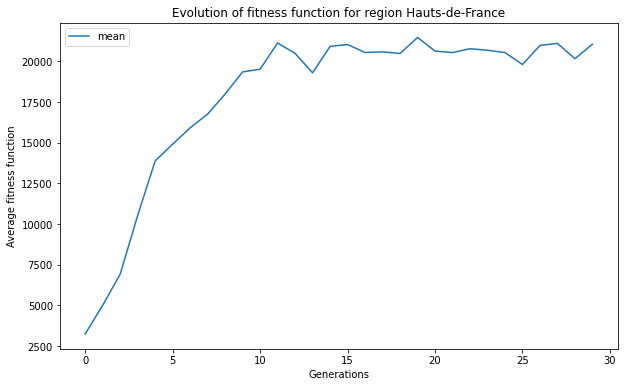

  8%|▊         | 1/12 [08:05<1:29:05, 485.99s/it]

Chosen stations in Hauts-de-France for 2030 are :       index            easting            northing  route  \
2585   2585   708011.472803343    7064667.02703473  A0022   
3159   3159  708264.7610351264   6972041.257965868  A0029   
9404   9404  654823.3843858116   6978015.559414283  N0025   
3150   3150   704759.498000003          6970744.27  A0029   
9718   9718   716247.899300002        6921152.8613  N0031   
9652   9652  659085.7480051693    6920289.41876353  N0031   
8966   8966  686349.7136019305   7032148.889999627  N0017   
9650   9650  657078.2098441024   6921248.337053038  N0031   
2708   2708  678857.0066313462   7038132.381421939  A0026   
9446   9446   652643.028108222   7001786.721562928  N0025   
2110   2110  642044.0570195575   6986112.835355642  A0016   
2529   2529  688083.9240800653   7039200.069618075  A0021   
9444   9444  652355.1256659712   7001212.703159407  N0025   
2154   2154  603763.7368888619   7054080.987665501  A0016   
175     175  698063.6581306768   70

100%|██████████| 30/30 [05:48<00:00, 11.61s/it]


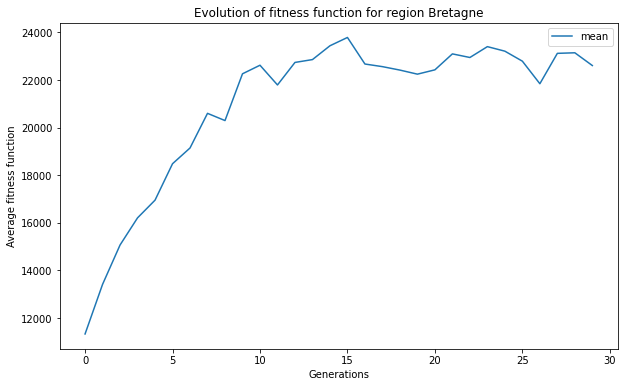

 17%|█▋        | 2/12 [14:12<1:09:19, 415.97s/it]

Chosen stations in Bretagne for 2030 are :        index             easting            northing  route  \
9360    9360   295995.7505027471   6772114.523393581  N0024   
12710  12710  245866.66729555136   6752793.259791643  N0165   
12531  12531    299866.450000003         6801737.291  N0164   
12762  12762  174045.94988739124   6795339.029320219  N0165   
12934  12934  337393.25746650505   6838452.665791013  N0176   
12599  12599  199531.29923091346   6812243.160906663  N0164   
11951  11951  350175.66622416873   6766443.058424335  N0137   
8757    8757   277467.2238270706    6837145.20386416  N0012   
12684  12684  283739.90499586123   6735246.008600292  N0165   
9341    9341   320980.3046301191   6779299.262037265  N0024   
12956  12956  308884.72964404547   6826099.785805727  N0176   
12697  12697  263350.14322832506   6745059.487213234  N0165   
8798    8798  227277.96139930142   6846845.528900042  N0012   
8696    8696    386766.504000001         6814118.268  N0012   
12945  12945

100%|██████████| 30/30 [06:04<00:00, 12.17s/it]


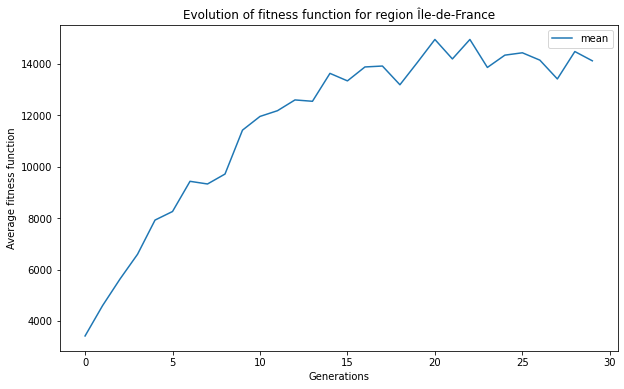

 25%|██▌       | 3/12 [20:34<1:00:03, 400.43s/it]

Chosen stations in Île-de-France for 2030 are :        index            easting            northing   route  \
7377    7377  653664.0246167881   6847350.080121711   N0007   
698      698  659271.6336433067   6832233.346640724   A0006   
12987  12987  633764.2631223524   6871262.224213736   N0184   
299      299   673981.972099997        6859111.1134   A0004   
703      703  663746.3782755994   6823459.551740541   A0006   
675      675  667179.1887690246   6835407.404608512  A0005A   
13011  13011  636568.5438429974   6883412.321078156   N0184   
6352    6352  652197.4744117261  6850891.8085645605   A0106   
324      324  710998.7639863992   6879163.548021011   A0004   
11286  11286  670427.3351610973   6846929.223719267   N0104   
11309  11309  658198.7651694164   6834672.087094777   N0104   
295      295   669668.516999997         6859438.857   A0004   
11329  11329   673128.957999997         6830523.174   N0105   
60        60  654333.8305901033   6870523.675521101   A0001   
279    

100%|██████████| 30/30 [05:53<00:00, 11.80s/it]


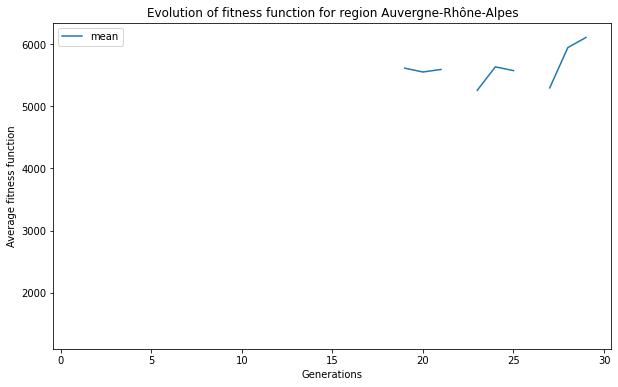

 33%|███▎      | 4/12 [26:44<51:46, 388.29s/it]  

Chosen stations in Auvergne-Rhône-Alpes for 2030 are :        index            easting            northing   route  \
7546    7546  776721.2016948459   6555567.296158244   N0007   
6762    6762  717777.9558957807   6525411.230503591   A0711   
11215  11215  772368.7875287633   6407825.240483484   N0102   
6579    6579  945999.3742428328   6549904.779027513   A0410   
8015    8015  840017.8667637634   6377377.583389521   N0007   
13496  13496  852322.1779274462   6521891.879556648   N0346   
7788    7788  842435.6429159043   6468534.532979818   N0007   
4042    4042  850197.8135770123   6515470.733904399   A0043   
7409    7409  719411.7960765577     6617551.5027416   N0007   
6222    6222  697931.3935628395   6538286.480269186   A0089   
6284    6284  795658.4698736579   6529566.356593878   A0089   
7425    7425  728791.5475332972   6608838.094924346   N0007   
8017    8017  840036.3398816729   6377349.938255705   N0007   
7413    7413   721249.150825191   6615134.960266443   N0007   


100%|██████████| 30/30 [05:03<00:00, 10.12s/it]


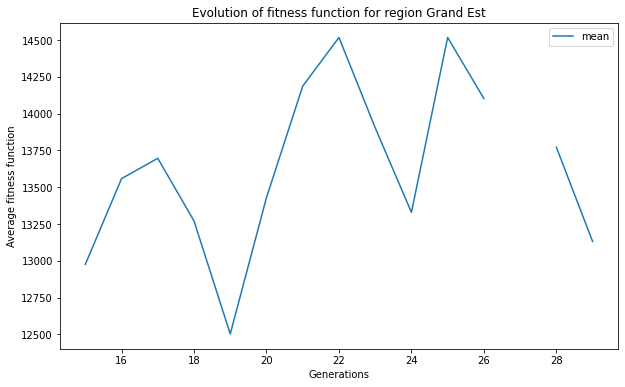

 42%|████▏     | 5/12 [32:02<42:19, 362.78s/it]

Chosen stations in Grand Est for 2030 are :        index             easting            northing  route  \
511      511  1011642.3581448721    6861189.19133465  A0004   
626      626   799644.0005517207   6786211.763271899  A0005   
9838    9838   970369.2070158552   6904989.230807836  N0033   
3340    3340   931710.9421887528   6897355.971555824  A0031   
3392    3392   824398.7197607465   6960795.087620621  A0034   
3385    3385    837624.016000003         6956714.625  A0034   
3442    3442   1061360.495301857  6861093.7486556815  A0035   
2856    2856   786386.3078715362    6797287.61021569  A0026   
9906    9906   843649.0883294223   6955763.003226013  N0043   
3510    3510  1048339.6145590075   6837218.456399013  A0035   
384      384   805303.5188424239   6882591.496508436  A0004   
7213    7213   878645.5989836855  6847604.8866341775  N0004   
3343    3343   932279.5471745495   6898307.746799124  A0031   
2816    2816   793986.0198267923   6875251.116448644  A0026   
636      63

100%|██████████| 30/30 [05:03<00:00, 10.13s/it]


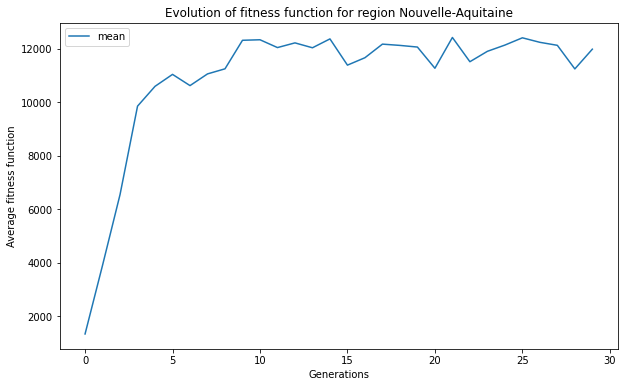

 50%|█████     | 6/12 [37:18<34:41, 346.85s/it]

Chosen stations in Nouvelle-Aquitaine for 2030 are :        index             easting           northing  route  \
1663    1663   426895.2337013515  6449580.069983143  A0010   
8410    8410   451757.5900926901  6485028.075512124  N0010   
8470    8470  385789.94180373586  6573351.980372177  N0011   
5685    5685    420611.325000003        6594885.682  A0083   
6827    6827   404213.1507859058   6542317.26920289  A0837   
6819    6819          393559.559        6547930.556  A0837   
4970    4970   445751.7501151588  6382087.802243563  A0065   
11835  11835    408952.154197727  6199377.976609605  N0134   
4752    4752   373947.6970394209  6327026.596610237  A0063   
8367    8367     482151.64315399  6552372.054524787  N0010   
12081  12081   562073.3510566955  6566439.703693014  N0145   
11840  11840  408745.51120994217  6197977.561385263  N0134   
6093    6093  484722.62868676503  6437818.923971678  A0089   
1673    1673    426340.881200001       6431658.2795  A0010   
12196  12196    5

100%|██████████| 30/30 [05:01<00:00, 10.06s/it]


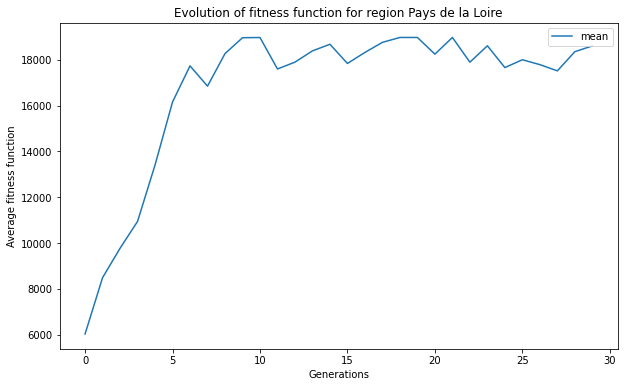

 58%|█████▊    | 7/12 [42:30<27:57, 335.58s/it]

Chosen stations in Pays de la Loire for 2030 are :        index             easting            northing  route  \
2963    2963    485581.922421898   6812564.373167418  A0028   
5595    5595   425644.8691244878   6783424.760919011  A0081   
12442  12442   423647.2721669622  6752744.1342041185  N0162   
13801  13801  350164.02505125396   6688592.406553847  N0844   
1749    1749  492414.92479480646   6776817.806467991  A0011   
11911  11911  352952.81205828977   6695961.317517807  N0137   
13249  13249   363178.8986363914   6689004.344616544  N0249   
12855  12855   326097.4825139531   6707591.916793945  N0171   
12853  12853    327943.159209574   6708376.732170018  N0171   
2948    2948   487574.3854085999    6785386.28363861  A0028   
13753  13753  359012.57772537443   6693171.473311064  N0844   
5668    5668   394032.2608104584   6607915.145634701  A0083   
2955    2955   489491.4825908917   6797757.229185716  A0028   
5688    5688   423439.1211304576   6595462.604895039  A0083   
8669

100%|██████████| 30/30 [04:41<00:00,  9.40s/it]


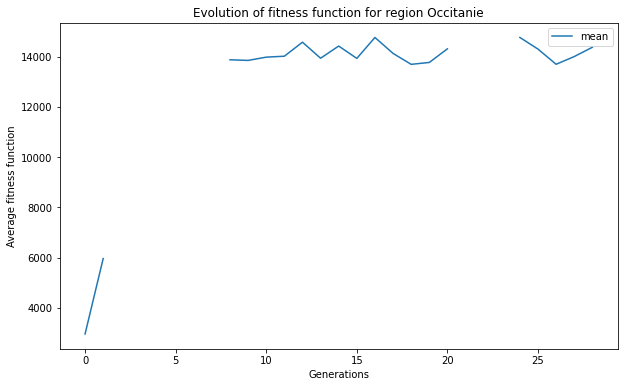

 67%|██████▋   | 8/12 [47:23<21:28, 322.18s/it]

Chosen stations in Occitanie for 2030 are :        index            easting            northing  route  \
11349  11349  800998.6182851881   6314321.992110474  N0106   
9082    9082  585933.5617137912   6197386.153810315  N0020   
1372    1372  688619.8958245994   6173843.397378132  A0009   
1374    1374  688373.9867045046   6169664.469197523  A0009   
6686    6686  570551.0735887432   6281580.282221557  A0621   
9083    9083   584690.879000001          6195802.55  N0020   
10821  10821  766260.1130442445   6402152.372562324  N0088   
4557    4557  665762.8654374996   6231168.550371832  A0061   
11130  11130    831715.00454021   6318353.121324358  N0100   
4951    4951  560521.5364288151   6254754.212747269  A0064   
11601  11601   624005.083999999         6390237.488  N0122   
9146    9146  610465.4996947232  6151832.7957590865  N0020   
4555    4555  661929.7432242464   6231239.092729962  A0061   
13968  13968   555988.612999998         6288880.303  P0224   
5413    5413   701726.9751

100%|██████████| 30/30 [04:48<00:00,  9.60s/it]


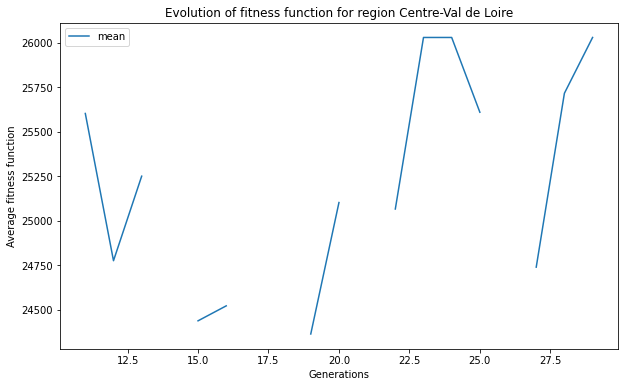

 75%|███████▌  | 9/12 [52:22<15:44, 314.86s/it]

Chosen stations in Centre-Val de Loire for 2030 are :        index            easting           northing  route  \
1444    1444   613653.317597204  6769721.033845355  A0010   
2310    2310  608034.5601972437  6659285.264033855  A0020   
2288    2288  625796.4920270671  6776869.578346587  A0019   
12302  12302   612399.027000003        6790334.846  N0154   
1719    1719  550032.3176780165  6793693.323065026  A0011   
8327    8327         548207.662        6732562.208  N0010   
1709    1709  568205.7309230895  6799318.071424751  A0011   
5819    5819  511857.3311260769  6693135.452319796  A0085   
2276    2276  647684.0992389875  6779194.724327843  A0019   
2292    2292  619310.6631242877  6772633.058412172  A0019   
1481    1481  562597.5579973242  6725620.889160827  A0010   
5826    5826  525656.9548022392  6691653.150887337  A0085   
1447    1447  614713.0310854072  6763696.622105563  A0010   
8290    8290  568141.2876734895   6765742.95350544  N0010   
12347  12347  581579.2068047774

100%|██████████| 30/30 [04:20<00:00,  8.67s/it]


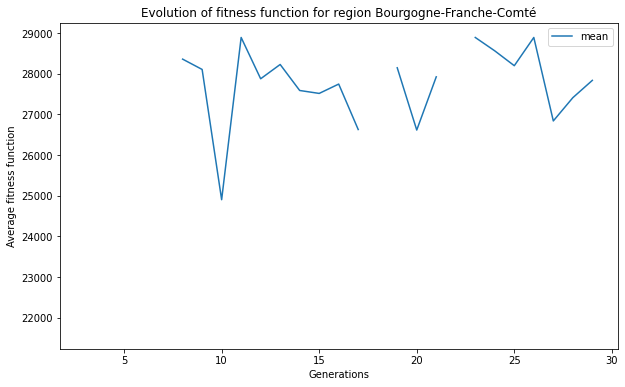

 83%|████████▎ | 10/12 [56:52<10:01, 300.97s/it]

Chosen stations in Bourgogne-Franche-Comté for 2030 are :        index            easting           northing  route  \
10127  10127  952963.0073844934  6660533.781141576  N0057   
10315  10315  743750.0018507307  6746701.760001358  N0077   
10544  10544  917847.9381442135  6662192.530091984  N0083   
804      804  796997.8076361412    6706023.3109728  A0006   
3762    3762  890034.4924467601  6657777.898509161  A0039   
3734    3734   856871.927000001        6691226.936  A0039   
10118  10118  951866.3094892739  6672571.871223085  N0057   
10552  10552  919712.9357916097  6670825.253802923  N0083   
13904  13904  993474.1328966923  6726543.942435217  N1019   
7390    7390  709704.4537087287  6631616.368381944  N0007   
3755    3755   881874.556000002        6670070.181  A0039   
10536  10536  913900.3302801938  6657412.673733253  N0083   
753      753  722881.1221128912  6756672.274044234  A0006   
7361    7361   744620.235915415  6746316.670940395  N0006   
7397    7397  711581.741560

100%|██████████| 30/30 [04:22<00:00,  8.76s/it]


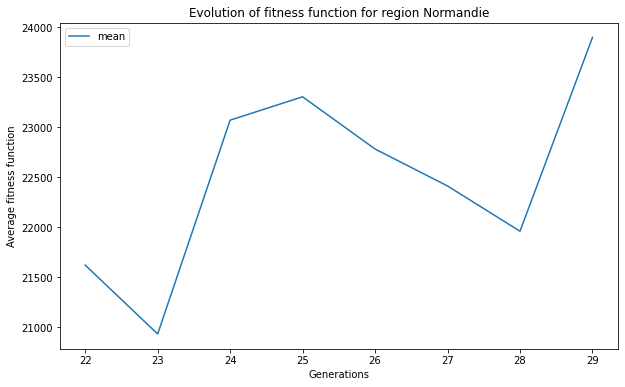

 92%|█████████▏| 11/12 [1:01:24<04:51, 291.95s/it]

Chosen stations in Normandie for 2030 are :        index             easting           northing  route  \
12896  12896  397044.47088848776  6916841.095170461  N0174   
2870    2870   601477.1165993954  6980298.549760377  A0028   
6057    6057   470000.8603601454   6862489.45816396  A0088   
2876    2876   593872.7111735374  6971267.323672352  A0028   
8871    8871    583989.601000004        6879956.162  N0013   
3030    3030   539424.7268172671  6913180.057605711  A0028   
9494    9494    558950.351364053  6956451.976416382  N0027   
8928    8928   400882.8016736031  6919848.967961603  N0013   
8602    8602   486408.1896219832  6820994.276153079  N0012   
5740    5740    386236.101778561  6861582.256984791  A0084   
13487  13487   557568.9589344767   6924970.35303797  N0338   
12888  12888   396627.8666434524  6902313.337629269  N0174   
12895  12895  397573.24519000575  6914957.817824263  N0174   
3011    3011   516072.8396828377  6889983.212720901  A0028   
6060    6060    469210.848

100%|██████████| 30/30 [04:14<00:00,  8.48s/it]


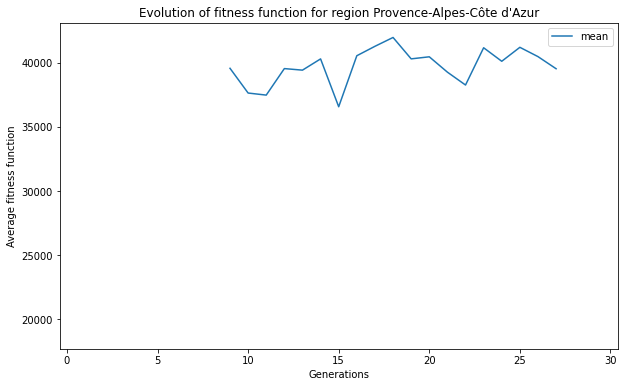

100%|██████████| 12/12 [1:05:47<00:00, 328.97s/it]

Chosen stations in Provence-Alpes-Côte d'Azur for 2030 are :        index             easting           northing  route  \
11085  11085    979927.392398086  6395765.333661447  N0094   
11092  11092   981659.5035367802  6416965.887369556  N0094   
1221    1221   1034616.366544784  6293213.536611884  A0008   
4358    4358    932160.829535436  6319575.935579198  A0051   
10712  10712   964378.7881490014  6326572.670511145  N0085   
1180    1180   977371.2214208295  6262983.628670599  A0008   
1238    1238   1054359.946511262  6304790.555236791  A0008   
1210    1210  1020928.7025356666  6281900.854015777  A0008   
1245    1245    842693.262000002        6339023.154  A0009   
11070  11070   952102.3659696958  6390971.582599821  N0094   
8195    8195    848184.351000004         6315893.45  N0007   
10626  10626   941301.6262558921  6405026.688059577  N0085   
11468  11468   840298.1824059144  6283312.880716567  N0113   
8117    8117   834393.5778417997   6358225.58060018  N0007   
13151  13

In [181]:
chosen_stations_2030 = pd.DataFrame([])
for region_name in tqdm(list_regions):
    print(f'Running genetic algorithm for {region_name}')
    
    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga_total(
        df_new_points[df_new_points[region_name]==True],
        nb_stations_per_region,                                                          
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2030_per_reg['Region'] = region_name

    chosen_stations_2030 = pd.concat([chosen_stations_2030,chosen_stations_2030_per_reg],axis=0)
    plot_fitness_functions(avg_fitness,region_name)
    print(f'Chosen stations in {region_name} for 2030 are : {chosen_stations_2030_per_reg}')


In [182]:
chosen_stations_2030 = sales(chosen_stations_2030, 2030)
chosen_stations_2030 = station_type(chosen_stations_2030,df_station_info)
chosen_stations_2030.to_csv('results_stations_2030_part_3_3.csv')

876.0


## 2040

In [16]:
chosen_stations_2030 = pd.read_csv('results_stations_2030_part_3_3.csv')
df_new_points_without_2030 = df_new_points.drop(index=chosen_stations_2030.index.values)

Running genetic algorithm for Hauts-de-France


100%|██████████| 30/30 [17:27<00:00, 34.90s/it]


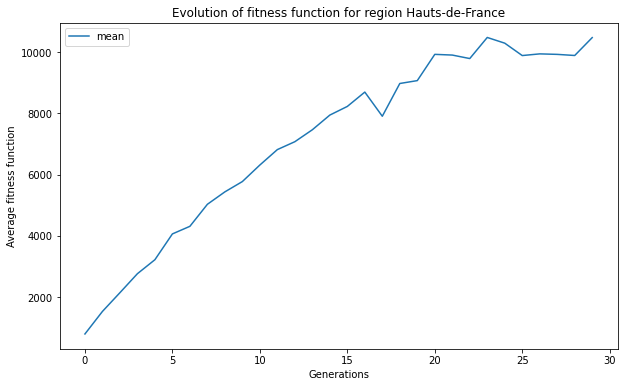

Chosen stations in Hauts-de-France for 2040 are : Int64Index([ 9648,  2140,  2725,  9710, 13460,  3157,  2528,  9403,  6860,
             2099,
            ...
             9759,  3141,  9694,  2561,  2557,  6874,  9629, 13472,  2146,
             2667],
           dtype='int64', length=222)
Running genetic algorithm for Bretagne


100%|██████████| 30/30 [13:48<00:00, 27.63s/it]


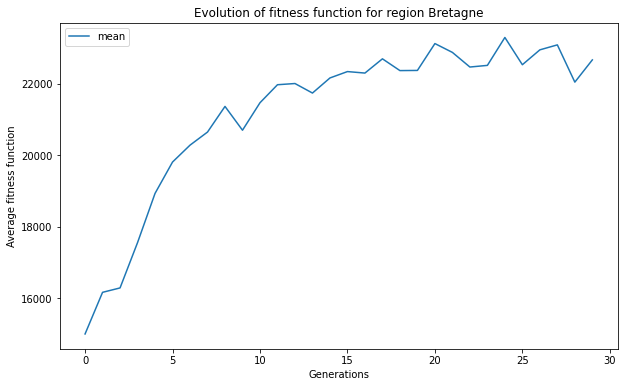

Chosen stations in Bretagne for 2040 are : Int64Index([ 8769, 12693, 12932,  9346, 12546, 12540,  8723, 12627, 12773,
            11855,
            ...
             8767,  8832,  5722,  9357, 12798, 12557, 12936,  5712,  8693,
            12588],
           dtype='int64', length=204)
Running genetic algorithm for Île-de-France


100%|██████████| 30/30 [14:52<00:00, 29.75s/it]


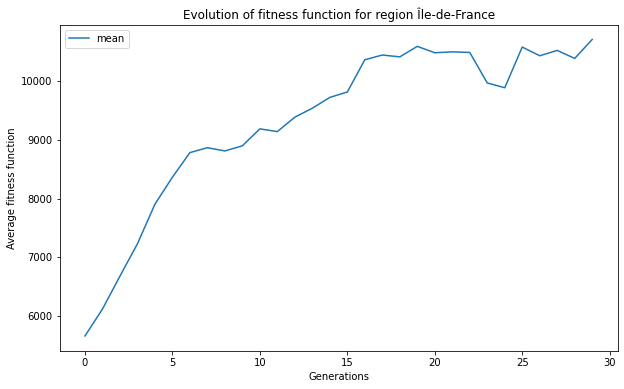

Chosen stations in Île-de-France for 2040 are : Int64Index([11298,  7137, 11309, 11273, 11261,  9855, 13066, 12971,   559,
             5906,
            ...
             5494,  8221,  8490, 11268,   695,  8992,   556, 11327,  1411,
            13089],
           dtype='int64', length=204)
Running genetic algorithm for Auvergne-Rhône-Alpes


100%|██████████| 30/30 [28:21<00:00, 56.70s/it]


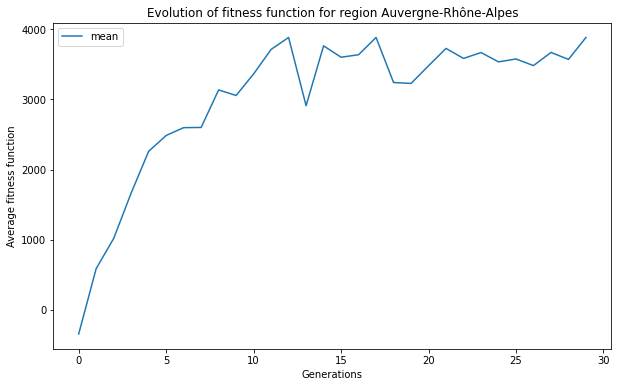

Chosen stations in Auvergne-Rhône-Alpes for 2040 are : Int64Index([ 4155,  7827,  7889,  8011,  8049,  7564,  7542,  6577,  6841,
             7435,
            ...
             4218, 11189,  7905,  7902,  4159, 11035,  7632, 11062,  4067,
             7652],
           dtype='int64', length=166)
Running genetic algorithm for Grand Est


100%|██████████| 30/30 [20:40<00:00, 41.34s/it]


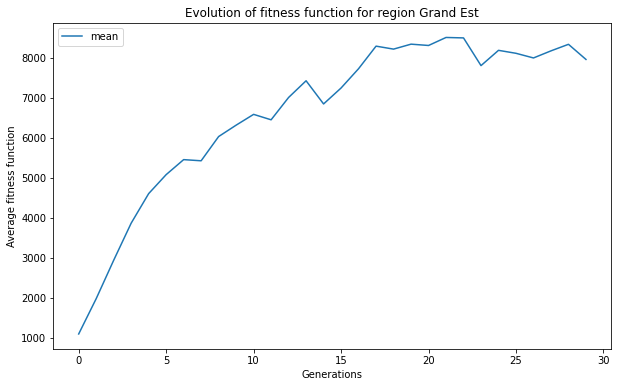

Chosen stations in Grand Est for 2040 are : Int64Index([ 7157,   391,  3330,  9841,  3319, 10244,  7264,  9835,   598,
              485,
            ...
              406, 10022,  3394,   498,   607,  9909,   442, 10202,  3481,
             3575],
           dtype='int64', length=166)
Running genetic algorithm for Nouvelle-Aquitaine


100%|██████████| 30/30 [14:09<00:00, 28.33s/it]


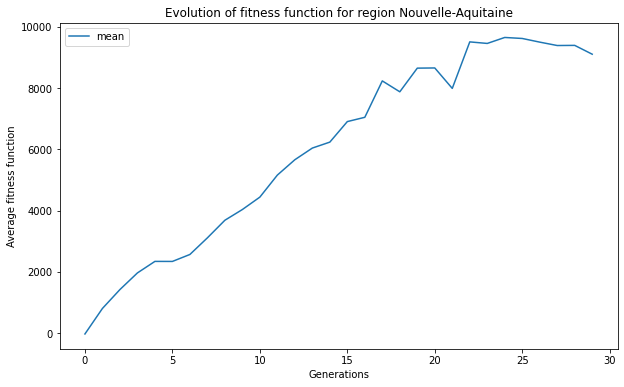

Chosen stations in Nouvelle-Aquitaine for 2040 are : Int64Index([ 1579, 11770,  9229,  6188,  1531,  2408,  1632,  4728, 13646,
             8412,
            ...
             9171,  6150,  1649,  4829,  2385,  4836,  6696,  6739,  6698,
             4888],
           dtype='int64', length=166)
Running genetic algorithm for Pays de la Loire


100%|██████████| 30/30 [14:24<00:00, 28.83s/it]


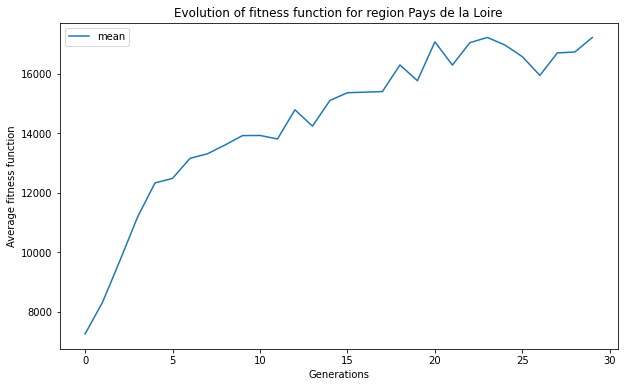

Chosen stations in Pays de la Loire for 2040 are : Int64Index([12477, 12461,  5593,  5638, 12500, 13770,  5964,  5963, 13799,
            13753,
            ...
             8638,  5979, 12462, 13579, 13760,  5688,  1753,  2933,  1803,
             1765],
           dtype='int64', length=166)
Running genetic algorithm for Occitanie


100%|██████████| 30/30 [11:54<00:00, 23.81s/it]


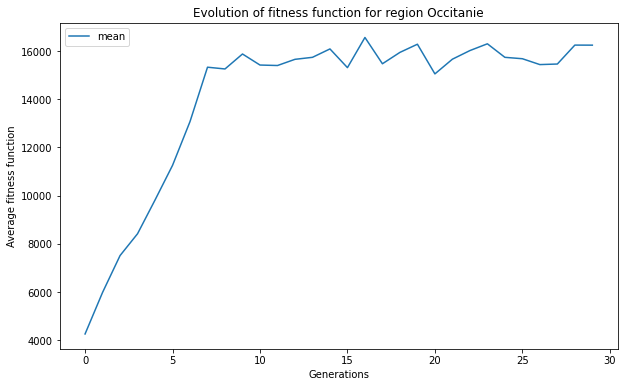

Chosen stations in Occitanie for 2040 are : Int64Index([ 5450,  9141,  1273,  9296,  9076,  4957,  6692, 10827,  1372,
             2516,
            ...
             5386, 11454,  5065,  2459,  2454,  6730,  5404,  2448,  1367,
            13406],
           dtype='int64', length=148)
Running genetic algorithm for Centre-Val de Loire


100%|██████████| 30/30 [10:26<00:00, 20.89s/it]


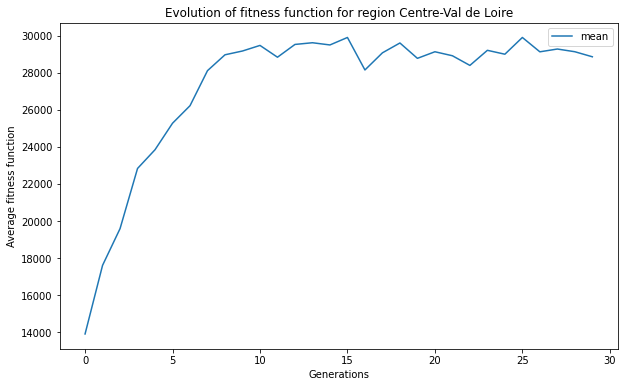

Chosen stations in Centre-Val de Loire for 2040 are : Int64Index([11689,  1684,  5139,  5124,  2332,  1529,  5132,  1462,  5110,
             8233,
            ...
             5875,  5815,  5153,  5095,  8307,  5146,  8268,  5877,  5109,
             8502],
           dtype='int64', length=130)
Running genetic algorithm for Bourgogne-Franche-Comté


100%|██████████| 30/30 [09:52<00:00, 19.76s/it]


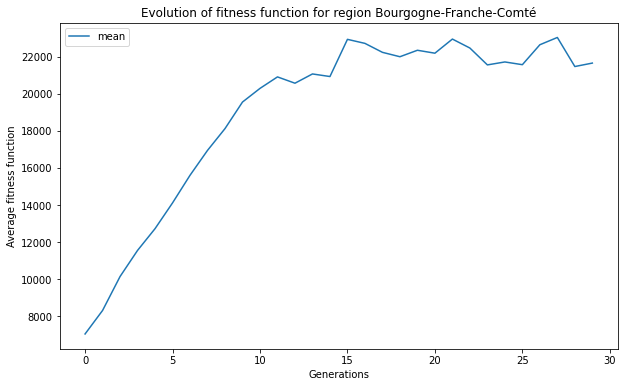

Chosen stations in Bourgogne-Franche-Comté for 2040 are : Int64Index([  868, 13331,   592,  5548, 10543, 13868, 10070,  3717, 12293,
              570,
            ...
              747,  7398,  3720, 10524,  7294,  7396,  3691, 10052, 10443,
              843],
           dtype='int64', length=111)
Running genetic algorithm for Normandie


100%|██████████| 30/30 [08:42<00:00, 17.41s/it]


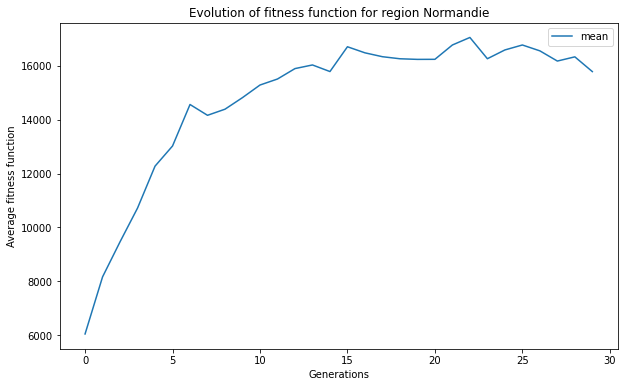

Chosen stations in Normandie for 2040 are : Int64Index([ 8875,  1951, 13483,  8551, 12408, 13482,  3027,  3078,  8920,
             2873,  5776,  3048,  1976,  1919,  1910,  6045,  8591,  8560,
             1925,  6047, 13835,  3012,  8883,  2972,  1951, 12917,  8528,
            13836,  8543,  6445,  1971,  9573,  1914,  2976,  1923, 12883,
            12882,  2874,  8925,  3087,  3088, 12379,  8586,  6444, 12963,
             8900,  3033,  5759,  2993, 13838,  8554,  6039,  5754,  1947,
            13840,  9496,  8917,  8934, 12365,  9544, 11967,  6033, 12381,
             9584,  5769,  8522,  1930,  3068,  9602,  1986, 12906,  1946,
             1929,  8939, 13727,  8532,  1966,  6434,  1911,  8613, 13721,
             1921,  8618, 12899,  2870,  8589, 12875,  3053,  6426, 12880,
            12370,  1961],
           dtype='int64')
Running genetic algorithm for Provence-Alpes-Côte d'Azur


100%|██████████| 30/30 [16:34<00:00, 33.14s/it] 


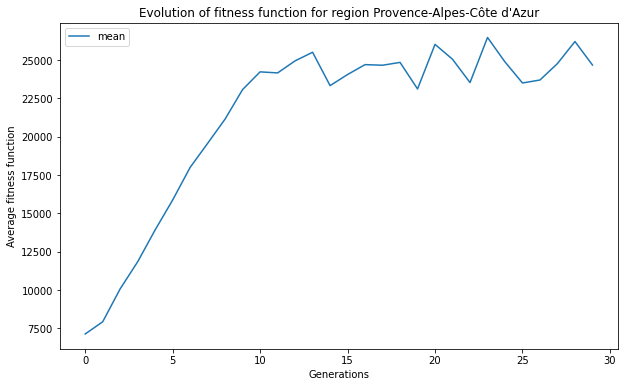

Chosen stations in Provence-Alpes-Côte d'Azur for 2040 are : Int64Index([ 8178, 11082, 10618,  1021, 10692, 10619,  1203,  1077,  1041,
            11094,  4471,  1081,  1139,  4292, 10688,  1191, 10708,  8171,
             8149,  4437, 13110,  4347,  4487,  8195, 13118, 10685,  1184,
             1088,  4377, 10704, 13679, 10694, 10614, 11087,  4285,  1032,
             6660,  1217, 10663,  1152,  1238, 10706,  8169,  8131,  1092,
             4409,  4476,  4364,  4326,  8147,  1137,  4484,  8194, 10612,
             8182,  8197,  1236,  8168,  8134,  4322, 13139,  4368,  4291,
             1222, 11071,  4487, 11084, 11766,  8165,  8192, 11080,  4416,
            10719,  1222],
           dtype='int64')


In [17]:
chosen_stations_no_total_2040 = pd.DataFrame([])

for region_name in list_regions:
    print(f'Running genetic algorithm for {region_name}')

    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {2040}'].values[0]

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga_total(
        df_new_points_without_2030[df_new_points_without_2030[region_name]==True],
        nb_stations_per_region, 
        region_name=region_name,
        year = 2040,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2040_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2040_per_reg['Region'] = region_name

    chosen_stations_no_total_2040 = pd.concat([chosen_stations_no_total_2040,chosen_stations_2040_per_reg],axis=0)

    plot_fitness_functions(avg_fitness,region_name)
    print(f'Chosen stations in {region_name} for 2040 are : {chosen_stations_2040_per_reg.index}')

In [19]:
chosen_stations_no_total_2040 = sales(chosen_stations_no_total_2040, 2040)
chosen_stations_no_total_2040 = station_type(chosen_stations_no_total_2040,df_station_info)
chosen_stations_no_total_2040.to_csv('results_stations_2040_part_3_3.csv')

876.0
